In [1]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 

# Get The Data 

In [2]:
data = pd.read_csv("../data/data_3_range.csv", header=None, names=["secenek", "cinsiyet", "sidmalzememarka", "UrunGrubu", "ResimAdresi", "YakaTipi", 
                                                            "CepOzelligi", "KolBoyuAciklama", "resimSira"])

In [3]:
data_img = data[["secenek","ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"]]
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    data_img.iloc[:, :2],
    data_img.iloc[:, 2:],
    test_size=0.25, 
    random_state=42
)

X_test.drop(index=[898, 745, 945], inplace=True) 
y_test.drop(index=[898, 745, 945], inplace=True) 

In [4]:
import os 
X_train["paths"] = X_train.index.copy() 
X_train["paths"] = X_train["paths"].apply(lambda x: os.path.join("../data/range_3_images_AYD/train/",str(x) + '.png')) 

X_test["paths"] = X_test.index.copy() 
X_test["paths"] = X_test["paths"].apply(lambda x: os.path.join("../data/range_3_images_AYD/test/",str(x) + '.png')) 

In [5]:
yaka_id = pd.Series(y_train.YakaTipi.value_counts().index).to_dict()  
cep_id = pd.Series(y_train.CepOzelligi.value_counts().index).to_dict()   
kolBoyu_id = pd.Series(y_train.KolBoyuAciklama.value_counts().index).to_dict()   

yaka_id = {v: k for k, v in yaka_id.items()}
cep_id = {v: k for k, v in cep_id.items()}
kolBoyu_id = {v: k for k, v in kolBoyu_id.items()}

y_train['YakaTipi_id'] = y_train['YakaTipi'].map(yaka_id)
y_train['CepOzelligi_id'] = y_train['CepOzelligi'].map(cep_id)
y_train['KolBoyuAciklama_id'] = y_train['KolBoyuAciklama'].map(kolBoyu_id)

y_test['YakaTipi_id'] = y_test['YakaTipi'].map(yaka_id)
y_test['CepOzelligi_id'] = y_test['CepOzelligi'].map(cep_id)
y_test['KolBoyuAciklama_id'] = y_test['KolBoyuAciklama'].map(kolBoyu_id)

Xy_train = pd.concat([X_train, y_train], axis=1).drop(columns=["secenek", "ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"])
Xy_test = pd.concat([X_test, y_test], axis=1).drop(columns=["secenek", "ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"]) 
Xy_test.head()  

,paths,YakaTipi_id,CepOzelligi_id,KolBoyuAciklama_id
2399,../data/range_3_images_AYD/test/2399.png,0,0,1
801,../data/range_3_images_AYD/test/801.png,0,0,0
2289,../data/range_3_images_AYD/test/2289.png,1,0,0
2345,../data/range_3_images_AYD/test/2345.png,0,0,0
3616,../data/range_3_images_AYD/test/3616.png,3,0,1


In [6]:
from custom_data_generator import AydFashionDataGenerator
custom_data_gen = AydFashionDataGenerator(Xy_train, Xy_test) 

In [7]:
train_set = custom_data_gen.generate_images(True, bathc_size=32, epoch=1)
test_set = custom_data_gen.generate_images(False, bathc_size=32, epoch=1)

# Model 3: VGG-16 Multi Output 

In [8]:
model_3 = tf.keras.models.load_model("../trained_models/model_3.h5")

In [11]:
model_3.evaluate(test_set)

35/35 [==============================] - 170s 5s/step - loss: 1.1883 - YakaTipi_loss: 0.4441 - CepOzelligi_loss: 0.5691 - KolBoyuAciklama_loss: 0.1750 - YakaTipi_precision_yakaTipi: 0.8607 - YakaTipi_recall_yakaTipi: 0.8384 - CepOzelligi_precision_cep: 0.8057 - CepOzelligi_recall_cep: 0.7848 - KolBoyuAciklama_precision_kol: 0.8471 - KolBoyuAciklama_recall_kol: 0.8402


[1.1882787942886353,
 0.4440896213054657,
 0.5691457986831665,
 0.17504343390464783,
 0.8606782555580139,
 0.8383928537368774,
 0.8056828379631042,
 0.7848214507102966,
 0.8471074104309082,
 0.8401639461517334]

In [157]:
def predict(paths: list, model: tf.keras.models.Model, dims: tuple = (224, 224, 3)):
    """
    model: model which you want to predict with   
    path: paths of the images 
    dims: default dim of the image 
    """ 
    result = dict()   
    for cls_n in model.outputs:
        result[cls_n.name] = [] 
        
    i = 0 
    for path in paths:
        img = tf.io.read_file(path) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, [dims[0], dims[1]]) 
        img = tf.reshape(img, [1, dims[0], dims[1], dims[2]])

        d = 0 
        y_hat = model.predict(img, verbose=0)
        for key in result.keys():
            result[key].append(y_hat[d].squeeze().tolist())
            d += 1 
            
        # result.append(model.predict(img, verbose=0)) 
        i = i + 1 
        if i % 100 == 0: 
            print(f"{i} th iteration. You have {len(paths)} inputs. ")

    return result

In [178]:
y_hat_dic = predict(X_test["paths"].to_list()[:5], 
        model_3)

In [175]:
def y_id_to_one_hot(y_test: pd.DataFrame):
    """
        y_test: it has to consist of just ids of outputs
        
        return list of one hot dummies for each output
    """
    result = dict() 
    for col in y_test: 
        result[col] = pd.get_dummies(y_test[col]).to_numpy().tolist() 
    
    return result

In [176]:
d = y_id_to_one_hot(y_test.iloc[:, 3:])

In [9]:
from multioutput_eval import MultiOutputModelTester
tester = MultiOutputModelTester(model_3, y_test.iloc[:300, 3:], X_test["paths"].to_list()[:300]) 

100 th iteration. You have 300 inputs. 
200 th iteration. You have 300 inputs. 
300 th iteration. You have 300 inputs. 


In [10]:
pd.DataFrame(tester.get_metrics())

,YakaTipi_id,CepOzelligi_id,KolBoyuAciklama_id
threshold,0.5000,0.5000,0.5000
precision_weighted,0.8302,0.8311,0.9417
recall_weighted,0.8300,0.8133,0.9367
f1_score_weighted,0.8263,0.8181,0.9381


In [11]:
batch = next(test_set)
one_bathc_inputs= batch[0]
one_bathc_outputs = batch[1] 

In [12]:
def get_labels_as_array_from_batch(outputs: dict, i_th: int):
    res = [] 
    for k,v in outputs.items():
        r = v[i_th] 
        if isinstance(r, np.ndarray) != True: 
            zeros = np.zeros((2), dtype="int")
            zeros[r] = 1 
            r = zeros 
        
        res.append(r)
    
    return res
    
get_labels_as_array_from_batch(one_bathc_outputs, 0)

[array([1., 0., 0., 0.]), array([1., 0., 0., 0.]), array([0, 1])]

In [13]:
yaka_id = {v: k for k, v in yaka_id.items()}
cep_id = {v: k for k, v in cep_id.items()}
kolBoyu_id = {v: k for k, v in kolBoyu_id.items()}
classes = dict() 
classes["YakaTipi_id"] = yaka_id 
classes["CepOzelligi_id"] = cep_id 
classes["KolBoyuAciklama_id"] = kolBoyu_id 

In [16]:
from multioutput_eval import custom_predict
from helpers import show_image 
show_image() 
custom_predict(model_3, one_bathc_inputs[20], get_labels_as_array_from_batch(one_bathc_outputs, 20), classes=classes)

1/1 [==============================] - 0s 157ms/step


,classes,preds,actuals
0,DÜĞMELI YAKA,0,0.0
1,BISIKLET YAKA,0,0.0
2,KAPIŞONLU,1,1.0
3,POLO YAKA,0,0.0
0,CEPSIZ,0,0.0
1,TEK CEP,0,0.0
2,ÇIFT CEP,0,0.0
3,KANGURU CEP,1,1.0
0,UZUN KOL,1,1.0
1,KISA KOL,0,0.0


In [21]:
import cv2 
import matplotlib.pyplot as plt 

def custom_predict(model: tf.keras.models.Model, input ,labels: list, classes: dict):
    df = pd.DataFrame() 

    input_x = cv2.resize(input, (224,224))     
    input_x = input_x.reshape(1,224,224,3) 
    result = model.predict(input_x)

    for i, key in enumerate(classes): 
        indexes = [v for v in classes[key].values()] 
        preds_ith = result[i].squeeze() 
        if len(preds_ith.shape) > 0:
            zeros = np.zeros(preds_ith.shape, dtype="int")
            zeros[np.argmax(preds_ith, axis=0)] = 1 
            preds_ith = zeros
        else:
            preds_ith[preds_ith >= 0.5] = 1 
            preds_ith[preds_ith < 0.5] = 0 
            preds_ith.dtype = "int"
            zeros = np.zeros((2), dtype="int")
            zeros[preds_ith] = 1 
            preds_ith = zeros 

        df = pd.concat([
            df,
            pd.DataFrame({
            "classes": indexes, 
            "preds": preds_ith,
            "actuals": labels[i]
        })
        ], axis=0)

    plt.imshow(input / 255.0)
    plt.show()

    return df

1/1 [==============================] - 0s 168ms/step


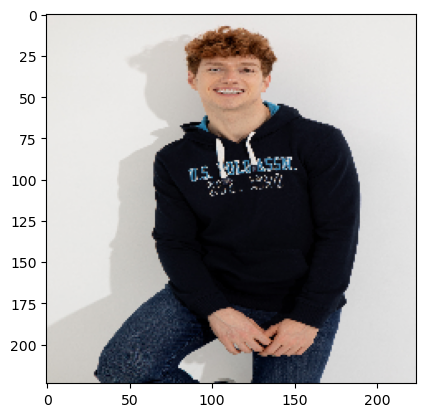

,classes,preds,actuals
0,DÜĞMELI YAKA,0,0.0
1,BISIKLET YAKA,0,0.0
2,KAPIŞONLU,1,1.0
3,POLO YAKA,0,0.0
0,CEPSIZ,0,0.0
1,TEK CEP,0,0.0
2,ÇIFT CEP,0,0.0
3,KANGURU CEP,1,1.0
0,UZUN KOL,1,1.0
1,KISA KOL,0,0.0


In [22]:
custom_predict(model_3, one_bathc_inputs[20], get_labels_as_array_from_batch(one_bathc_outputs, 20), classes=classes)